In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import GPy
import gp_grid
gp_grid.debug()

[ 14:15:50 ] matplotlib.backends DEBUG: backend module://ipykernel.pylab.backend_inline version unknown


First generate a dataset using a random covariance in the ''network'' space and using an rbf kernel in the temporal dimension.

In [2]:
np.random.seed(0)
n_network = 3 # number of networks
n_time = 200
N = n_network*n_time

# get a random network covariance matrix
K_n = 2*np.random.rand(n_network,n_network)-1;    K_n = K_n*K_n.T + 0.1*np.identity(n_network) # make spd

# specify a time covariance function
k_t = gp_grid.kern.RBF(1, lengthscale=0.2)
k_t.constraint_map['variance'] = 'fixed'
k_t.constraint_map['lengthscale'] = 'fixed'

# create a dataset
noise_var = 1e-6
t = np.linspace(0,5,num=n_time).reshape((-1,1))
xg = [np.arange(n_network).reshape((-1,1)),t]
# x = gp_grid.grid.grid2mat(*xg) # convert from grid to actual points
yg = np.random.multivariate_normal(np.zeros(N), np.kron(K_n,k_t.cov(t))+noise_var*np.identity(N)).reshape((n_network,n_time))

[ 14:15:50 ] gp_grid.kern DEBUG: Initializing RBF kernel.


plot the network and the covariance

network covariance matrix:
[[ 0.10953103  0.03863353 -0.025655  ]
 [ 0.03863353  0.12331436  0.2286295 ]
 [-0.025655    0.2286295   0.95993262]]
[ 14:15:50 ] matplotlib.font_manager DEBUG: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/trefor/anaconda2/envs/tensorflow/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


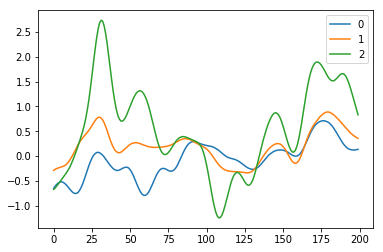

In [3]:
plt.figure()
for i in range(n_network):
    plt.plot(yg[i,:],label='%d'%i)
plt.legend(loc=0)

# plt.figure()
# plt.imshow(np.abs(K_n),interpolation='none')
print "network covariance matrix:"
print K_n

initialize the kernels with a random guess at the network covariance matrix and train the model to try and recover the original one model

In [5]:
print "exact covariance:"
print K_n

# get random covariance to initialize
# np.random.seed(5)
# K_init = 2*np.random.rand(n_network,n_network)-1; K_init = K_init.dot(K_init.T)

# compute mle covariance assuming no time dependence
K_init = np.cov(yg)

# print statistics of intial guess
print "\ninitial network covariance matrix:"
print K_init
print "\n% error between initial and exact covariance matricies:"
print (K_init-K_n) / K_n * 100

# now optimize the covariance matrix
kern_list = [gp_grid.kern.DirectCovariance(K=K_init), k_t]
m_kml = gp_grid.models.GPGridRegression(xg,yg,kern_list, noise_var=noise_var)
m_kml.noise_var_constraint = 'fixed'
m_kml.optimize(factr=1e7)
# print m_kml
K_recovered = m_kml.kern.kern_list[0].cov(np.arange(n_network).reshape((-1,1)))
print "\noptimized network covariance matrix:"
print K_recovered
print "\nerror between optimized and exact covariance matricies:"
print K_recovered-K_n
print "\n% error between optimized and exact covariance matricies:"
print (K_recovered-K_n) / K_n * 100

# ensure that the relative error is significantly less after MLE
before_norm = np.linalg.norm((K_init-K_n) / K_n * 100)
after_norm = np.linalg.norm((K_recovered-K_n) / K_n * 100)
improvement = after_norm/before_norm
print improvement
assert improvement < 0.15, "MLE didn't sufficiently decrease the covariance error."
print "done tests!"

exact covariance:
[[ 0.10953103  0.03863353 -0.025655  ]
 [ 0.03863353  0.12331436  0.2286295 ]
 [-0.025655    0.2286295   0.95993262]]

initial network covariance matrix:
[[0.13277108 0.05967274 0.10356408]
 [0.05967274 0.10739896 0.2546168 ]
 [0.10356408 0.2546168  0.80146744]]

% error between initial and exact covariance matricies:
[[  21.2177758    54.45840426 -503.67995751]
 [  54.45840426  -12.90636022   11.36655577]
 [-503.67995751   11.36655577  -16.50794835]]
[ 14:16:03 ] gp_grid.models DEBUG: Initializing GPGridRegression model.
[ 14:16:03 ] gp_grid.models DEBUG: Beginning MLE to optimize hyperparameters. grad_method=adjoint
[ 14:16:04 ] gp_grid.models INFO: Function Evals: 15. Log-Marginal Likelihood: 2603.86.

optimized network covariance matrix:
[[ 0.11577354  0.02163505 -0.01642613]
 [ 0.02163505  0.11957274  0.25592473]
 [-0.01642613  0.25592473  0.80641085]]

error between optimized and exact covariance matricies:
[[ 0.0062425  -0.01699848  0.00922887]
 [-0.01699848 -0